In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

In [31]:
transform = transforms.Compose([
    transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     transforms.Resize((224,224))
     ])

In [61]:
trainset = torchvision.datasets.Caltech101(root='./data', 
                                        download=False, transform=transform)
len(trainset)
train, test = torch.utils.data.random_split(trainset,[6000,2677])


train = torch.utils.data.DataLoader(train, batch_size=4,
                                          shuffle=True)

test = torch.utils.data.DataLoader(test, batch_size=4,
                                          shuffle=False)

# testset = torchvision.datasets.Caltech101(root='./data', train=False,
#                                        download=True, transform=None)
# testloader = torch.utils.data.DataLoader(testset, batch_size=4,
#                                          shuffle=False)

In [63]:
test

minaret sunflower kangaroo BACKGROUND_Google


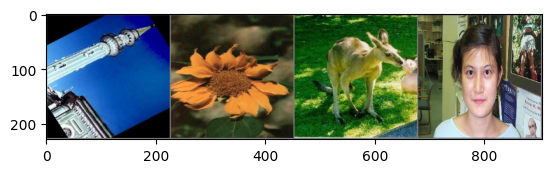

In [64]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(train)
images, label = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % labels[label[j]] for j in range(4)))

In [56]:
import os
labels = []
with os.scandir('/workspace/alexnet/data/caltech101/101_ObjectCategories') as class_labels:
    for class_label in class_labels:
        labels.append(class_label.name)

In [66]:
num_classes = len(labels)
num_classes

103

In [ ]:
class Net(nn.Module):
    def __init__(self,num_classes):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels= 3, out_channels=96, kernel_size = (11,11), stride= 4)
        self.norm = nn.LocalResponseNorm(5, k=2, alpha=0.00004, beta=0.75) #k = 2, n = 5, α = 10−4, and β = 0.75.
        self.pool = nn.MaxPool2d(2,2)
        self.dropout = nn.dropout(0.5)
        self.conv2 = nn.Conv2d(96, 256, 5)
        self.conv3 = nn.Conv2d(256, 384, 3)
        self.conv4 = nn.Conv2d(384, 384, 3)
        self.conv5 = nn.Conv2d(384, 256, 3)
        self.fc1 = nn.Linear((256 * 6 * 6), 4096) #256 * 6 * 6) to flatten
        self.fc2 = nn.Linear(4096,4096)
        self.fc3 = nn.Linear(4096,)

    def forward(self,x):
        x = self.pool(self.norm(F.relu(self.conv1(x))))
        x = self.pool(self.norm(F.relu(self.conv2(x))))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool(F.relu(self.conv5(x)))
        x = x.view(-1, 256 * 6 * 6)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)      
        return x

